In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.7410 eloss:3.8022 aloss2:2.2183 exploreP:0.9984
Episode:1 meanR:21.0000 R:26.0000 rate:0.0520 aloss:0.7292 eloss:3.8462 aloss2:2.1854 exploreP:0.9959
Episode:2 meanR:18.0000 R:12.0000 rate:0.0240 aloss:0.7314 eloss:3.8461 aloss2:2.1761 exploreP:0.9947
Episode:3 meanR:17.0000 R:14.0000 rate:0.0280 aloss:0.7276 eloss:3.8243 aloss2:2.1759 exploreP:0.9933
Episode:4 meanR:15.6000 R:10.0000 rate:0.0200 aloss:0.7772 eloss:3.7883 aloss2:2.2057 exploreP:0.9923
Episode:5 meanR:16.0000 R:18.0000 rate:0.0360 aloss:0.7219 eloss:3.7355 aloss2:2.2493 exploreP:0.9905
Episode:6 meanR:19.7143 R:42.0000 rate:0.0840 aloss:0.7302 eloss:3.7503 aloss2:2.2184 exploreP:0.9864
Episode:7 meanR:19.0000 R:14.0000 rate:0.0280 aloss:0.7312 eloss:3.7363 aloss2:2.2336 exploreP:0.9851
Episode:8 meanR:18.1111 R:11.0000 rate:0.0220 aloss:0.7312 eloss:3.7767 aloss2:2.1812 exploreP:0.9840
Episode:9 meanR:18.6000 R:23.0000 rate:0.0460 aloss:0.7347 eloss:3.6638 aloss2:2.2

Episode:80 meanR:21.3951 R:15.0000 rate:0.0300 aloss:0.7132 eloss:3.2337 aloss2:2.3652 exploreP:0.8425
Episode:81 meanR:21.4878 R:29.0000 rate:0.0580 aloss:0.7027 eloss:3.2445 aloss2:2.3592 exploreP:0.8401
Episode:82 meanR:21.3735 R:12.0000 rate:0.0240 aloss:0.7106 eloss:3.2340 aloss2:2.3448 exploreP:0.8391
Episode:83 meanR:21.2500 R:11.0000 rate:0.0220 aloss:0.7145 eloss:3.2277 aloss2:2.3734 exploreP:0.8382
Episode:84 meanR:21.1412 R:12.0000 rate:0.0240 aloss:0.7071 eloss:3.2283 aloss2:2.3636 exploreP:0.8372
Episode:85 meanR:21.1512 R:22.0000 rate:0.0440 aloss:0.7056 eloss:3.2106 aloss2:2.3787 exploreP:0.8353
Episode:86 meanR:21.2069 R:26.0000 rate:0.0520 aloss:0.7176 eloss:3.2152 aloss2:2.3462 exploreP:0.8332
Episode:87 meanR:21.0909 R:11.0000 rate:0.0220 aloss:0.7044 eloss:3.2005 aloss2:2.3736 exploreP:0.8323
Episode:88 meanR:21.1910 R:30.0000 rate:0.0600 aloss:0.7097 eloss:3.2057 aloss2:2.3702 exploreP:0.8298
Episode:89 meanR:21.0556 R:9.0000 rate:0.0180 aloss:0.7137 eloss:3.1884 a

Episode:159 meanR:20.8800 R:12.0000 rate:0.0240 aloss:0.6957 eloss:3.1311 aloss2:2.3122 exploreP:0.7149
Episode:160 meanR:20.9900 R:41.0000 rate:0.0820 aloss:0.6865 eloss:3.1367 aloss2:2.3315 exploreP:0.7120
Episode:161 meanR:21.1600 R:34.0000 rate:0.0680 aloss:0.6862 eloss:3.1315 aloss2:2.3167 exploreP:0.7096
Episode:162 meanR:21.2600 R:19.0000 rate:0.0380 aloss:0.6823 eloss:3.1635 aloss2:2.2965 exploreP:0.7083
Episode:163 meanR:21.9200 R:79.0000 rate:0.1580 aloss:0.6843 eloss:3.1547 aloss2:2.3105 exploreP:0.7028
Episode:164 meanR:22.2700 R:50.0000 rate:0.1000 aloss:0.7046 eloss:3.1565 aloss2:2.3163 exploreP:0.6993
Episode:165 meanR:22.4300 R:35.0000 rate:0.0700 aloss:0.7037 eloss:3.1674 aloss2:2.3030 exploreP:0.6969
Episode:166 meanR:22.9900 R:78.0000 rate:0.1560 aloss:0.6916 eloss:3.1728 aloss2:2.3203 exploreP:0.6916
Episode:167 meanR:23.4800 R:61.0000 rate:0.1220 aloss:0.7035 eloss:3.1795 aloss2:2.3086 exploreP:0.6874
Episode:168 meanR:24.4900 R:128.0000 rate:0.2560 aloss:0.6988 el

Episode:238 meanR:111.3200 R:500.0000 rate:1.0000 aloss:0.7438 eloss:3.3251 aloss2:2.2744 exploreP:0.2546
Episode:239 meanR:116.1600 R:500.0000 rate:1.0000 aloss:0.7405 eloss:3.3143 aloss2:2.2709 exploreP:0.2427
Episode:240 meanR:116.7900 R:75.0000 rate:0.1500 aloss:0.7520 eloss:3.3315 aloss2:2.2585 exploreP:0.2410
Episode:241 meanR:121.5100 R:500.0000 rate:1.0000 aloss:0.7464 eloss:3.3146 aloss2:2.2692 exploreP:0.2297
Episode:242 meanR:126.3400 R:500.0000 rate:1.0000 aloss:0.7416 eloss:3.3122 aloss2:2.2684 exploreP:0.2190
Episode:243 meanR:131.0100 R:500.0000 rate:1.0000 aloss:0.7320 eloss:3.3073 aloss2:2.2627 exploreP:0.2088
Episode:244 meanR:135.8600 R:500.0000 rate:1.0000 aloss:0.7347 eloss:3.3029 aloss2:2.2586 exploreP:0.1991
Episode:245 meanR:140.4200 R:500.0000 rate:1.0000 aloss:0.7317 eloss:3.2927 aloss2:2.2599 exploreP:0.1899
Episode:246 meanR:145.2400 R:500.0000 rate:1.0000 aloss:0.7244 eloss:3.2943 aloss2:2.2487 exploreP:0.1811
Episode:247 meanR:149.7800 R:500.0000 rate:1.00

Episode:316 meanR:452.4000 R:500.0000 rate:1.0000 aloss:0.5973 eloss:3.1527 aloss2:2.2222 exploreP:0.0152
Episode:317 meanR:456.1500 R:500.0000 rate:1.0000 aloss:0.5968 eloss:3.1615 aloss2:2.2155 exploreP:0.0149
Episode:318 meanR:456.6900 R:444.0000 rate:0.8880 aloss:0.5949 eloss:3.1610 aloss2:2.2114 exploreP:0.0147
Episode:319 meanR:458.1700 R:500.0000 rate:1.0000 aloss:0.5886 eloss:3.1636 aloss2:2.2004 exploreP:0.0145
Episode:320 meanR:462.5500 R:500.0000 rate:1.0000 aloss:0.5863 eloss:3.1639 aloss2:2.1989 exploreP:0.0143
Episode:321 meanR:466.9400 R:500.0000 rate:1.0000 aloss:0.5888 eloss:3.1621 aloss2:2.2012 exploreP:0.0140
Episode:322 meanR:468.0200 R:194.0000 rate:0.3880 aloss:0.5939 eloss:3.1707 aloss2:2.2066 exploreP:0.0140
Episode:323 meanR:466.4500 R:290.0000 rate:0.5800 aloss:0.5950 eloss:3.1734 aloss2:2.2094 exploreP:0.0139
Episode:324 meanR:466.9300 R:204.0000 rate:0.4080 aloss:0.5831 eloss:3.1623 aloss2:2.2063 exploreP:0.0138
Episode:325 meanR:468.0900 R:184.0000 rate:0.3

Episode:394 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5308 eloss:3.0175 aloss2:2.1923 exploreP:0.0103
Episode:395 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5092 eloss:3.0035 aloss2:2.1822 exploreP:0.0103
Episode:396 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5169 eloss:3.0049 aloss2:2.1945 exploreP:0.0103
Episode:397 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5093 eloss:2.9878 aloss2:2.1846 exploreP:0.0103
Episode:398 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5057 eloss:2.9812 aloss2:2.1855 exploreP:0.0103
Episode:399 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5115 eloss:2.9850 aloss2:2.1894 exploreP:0.0103
Episode:400 meanR:386.5100 R:500.0000 rate:1.0000 aloss:0.5099 eloss:2.9748 aloss2:2.1958 exploreP:0.0102
Episode:401 meanR:385.5200 R:401.0000 rate:0.8020 aloss:0.4998 eloss:2.9742 aloss2:2.1906 exploreP:0.0102
Episode:402 meanR:385.5200 R:500.0000 rate:1.0000 aloss:0.4998 eloss:2.9685 aloss2:2.1852 exploreP:0.0102
Episode:403 meanR:385.5200 R:500.0000 rate:1.0

Episode:472 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3801 eloss:2.0660 aloss2:2.9859 exploreP:0.0100
Episode:473 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3778 eloss:2.0580 aloss2:2.9845 exploreP:0.0100
Episode:474 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3771 eloss:2.0333 aloss2:2.9905 exploreP:0.0100
Episode:475 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3770 eloss:2.0397 aloss2:2.9979 exploreP:0.0100
Episode:476 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3776 eloss:2.0173 aloss2:2.9907 exploreP:0.0100
Episode:477 meanR:494.0900 R:500.0000 rate:1.0000 aloss:0.3769 eloss:1.9947 aloss2:2.9947 exploreP:0.0100
Episode:478 meanR:496.0600 R:500.0000 rate:1.0000 aloss:0.3771 eloss:1.9866 aloss2:2.9944 exploreP:0.0100
Episode:479 meanR:496.0600 R:500.0000 rate:1.0000 aloss:0.3796 eloss:1.9825 aloss2:2.9924 exploreP:0.0100
Episode:480 meanR:496.0600 R:500.0000 rate:1.0000 aloss:0.3775 eloss:1.9816 aloss2:2.9957 exploreP:0.0100
Episode:481 meanR:496.0600 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

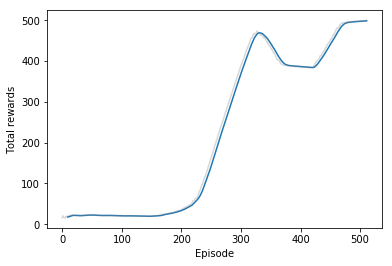

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

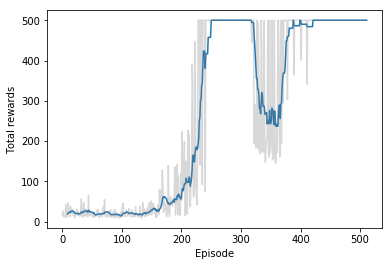

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

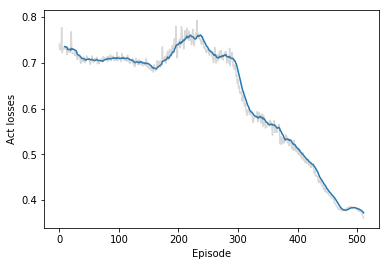

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

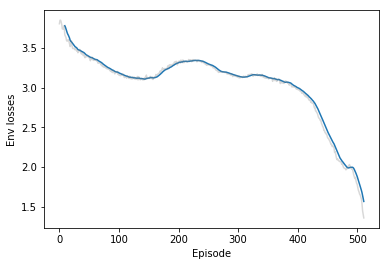

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

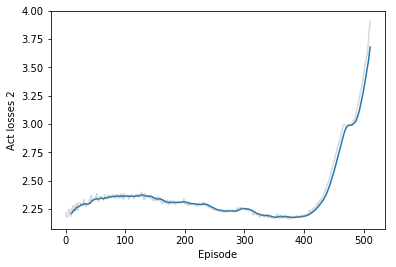

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
